In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches

In [117]:
# Load labor capacity data
ds = xr.open_dataset('../data/processed/GFDL/Monthly_Capacity/monthly_capacity_ens1-3_1950-2100.nc').rename({'__xarray_dataarray_variable__':'capacity'})

In [118]:
ds_base = ds.sel(time=slice('1980-01-31','1999-12-31')).mean(dim='ensemble').groupby('time.month').mean()['capacity']

In [119]:
ds = ds.sel(time=slice('2000-01-31',None))['capacity']

In [129]:
test_ds = ds.to_dataset()

In [136]:
test_ds['base'] = ds_base.sel(month=test_ds['time.month'],lat=test_ds['lat'],lon=test_ds['lon'])

In [142]:
ds_under = test_ds['capacity']<test_ds['base']

In [147]:
ds_3 = ds_under.groupby('time.year').sum() > 3

In [146]:
def emergence(ds,start_year):
    ds_thres = ds.nonzero()
    
    # If non-empty, index + startyear = ToE
    if len(ds_thres[0]) > 0:
        return start_year+(ds_thres[0][0].item())
    
    # If empty, return year after 2100
    return 2101

In [154]:
result = xr.apply_ufunc(emergence,ds_3,input_core_dims=[['year']],vectorize=True,kwargs={'start_year':2000})

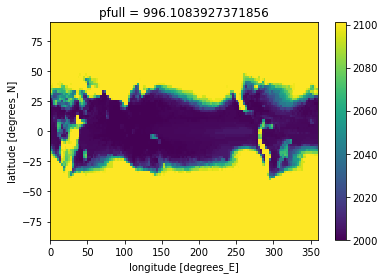

In [155]:
result.mean('ensemble').plot()

In [11]:
from dask.diagnostics import ProgressBar

In [2]:
ds = xr.open_dataset('../data/processed/GFDL/Monthly_Capacity/monthly_capacity_ens001-003_1950-2100.nc').rename({'__xarray_dataarray_variable__':'capacity'})

In [3]:
ds_base = lf.calc_baseline(ds)

In [4]:
ds_esm2m = ds.sel(time=slice('2000-01-31',None))['capacity']

In [50]:
def seasonal(month,hemisphere):
    if hemisphere=='n':
        return (month =
    elif hemisphere=='s':
        return (month == 12) | (month == 1) | (month == 2)
    else:
        raise ValueError('Hemisphere not valid')

In [86]:
ds = ds_esm2m
# Split into hemispheres, then pick out summer months
ds_north = ds.where(ds['lat']>0,drop=True)
ds_north = ds_north.sel(time=seasonal(ds_north['time.month'],'n'))

ds_south = ds.where(ds['lat']<0,drop=True)
ds_south = ds_south.sel(time=seasonal(ds_south['time.month'],'s'))

In [106]:
thres = 0.9
north_thres = ds_north < (thres*ds_base.sel(month=ds_north['time.month']))
south_thres = ds_south < (thres*ds_base.sel(month=ds_south['time.month']))

In [89]:
north_thres = north_thres.groupby('time.year').sum()
south_thres = south_thres.groupby('time.year').sum()

In [90]:
start_year=2000

north_toe = xr.apply_ufunc(lf.emergence2,north_thres,input_core_dims=[['year']],vectorize=True,dask='allowed',kwargs={'start_year':start_year})
south_toe = xr.apply_ufunc(lf.emergence2,south_thres,input_core_dims=[['year']],vectorize=True,dask='allowed',kwargs={'start_year':start_year})

In [91]:
xr.concat([south_toe,north_toe],dim='lat')

<xarray.DataArray 'capacity' (ensemble: 3, lat: 90, lon: 144)>
array([[[2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        ...,
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101]],

       [[2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        ...,
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101]],

       [[2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        ...,
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101],
        [2101, 2101, 2101, ..., 2101, 2101, 2101]]])
Coordinates:
    pfull    float64 996.1
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
Dimensions without coordinates: ensemble

# Try Again

In [154]:
labor_thres = [0.9,0.8,0.7]

# Calculate ToEs for all grid cells and ensemble members
ds_toe = lf.toe_summer(ds_esm2m,ds_base,labor_thres)

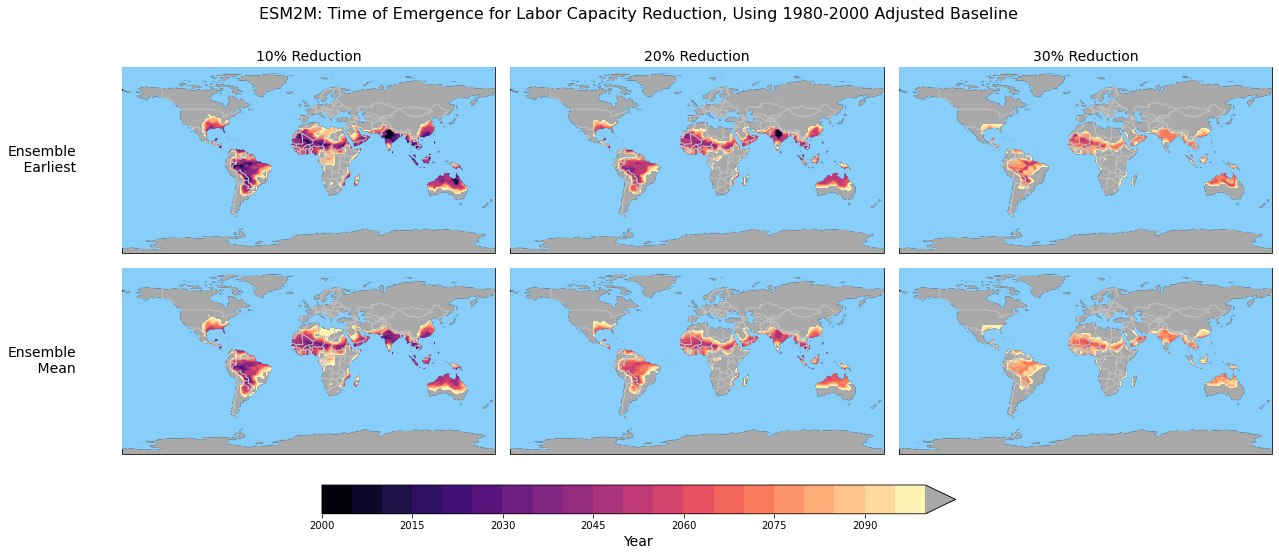

In [155]:
lf.spatial_toe(ds_toe,'ESM2M: Time of Emergence for Labor Capacity Reduction, Using 1980-2000 Adjusted Baseline')

In [195]:
ds = ds_esm2m
region = 'Central Africa'
model = 'GFDL'

ds_region = lf.slice_region(ds,region,model)
capacity = ds_region.mean(['lat','lon'])

In [196]:
ds_region['lat'].mean()

<xarray.DataArray 'lat' ()>
array(0.)
Coordinates:
    pfull    float64 996.1

In [194]:
ds_toe

<xarray.Dataset>
Dimensions:  (ensemble: 3, lat: 2)
Coordinates:
    pfull    float64 996.1
  * lat      (lat) float64 19.21 19.21
Dimensions without coordinates: ensemble
Data variables:
    0.9      (lat, ensemble) int64 2101 2101 2101 2056 2039 2048
    0.8      (lat, ensemble) int64 2101 2101 2101 2070 2072 2065
    0.7      (lat, ensemble) int64 2101 2101 2101 2084 2085 2085